In [ ]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
%matplotlib inline

from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble

# __Gradient boost guided example__
---

We will be walking through gradient boost using SKlearn.  We'll use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [ ]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]

We're now working with a binary outcome, so we've switched to a classifier.  Our loss function can't be the residuals.  

Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [ ]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.

# *** It's best to update this table for the drill 
#  at the end of the lesson.  ***

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

### __Evaluation of Model - Confusion Matrix Plot__

based on the example here:

https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

In [ ]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


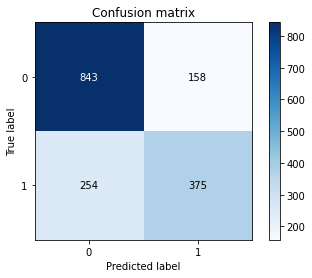

In [ ]:
# Confusion matrix without normalization -- TEST Set
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


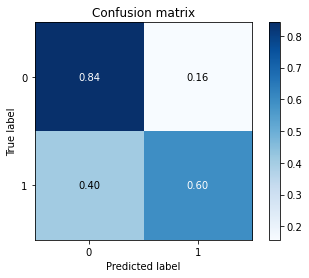

In [ ]:
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],True)

Confusion matrix, without normalization


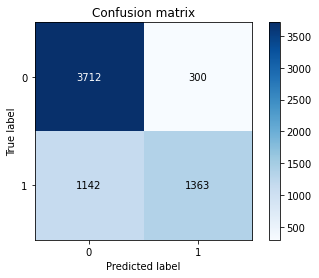

In [ ]:
# Confusion matrix for Train Set

# Confusion matrix without normalization
cm_train = confusion_matrix(y_train, predict_train)
plot_confusion_matrix(cm_train,[0,1],False)

Normalized confusion matrix


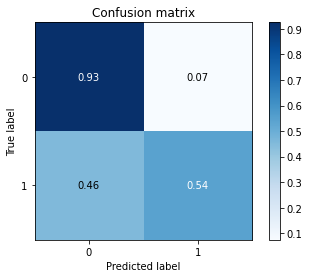

In [ ]:
cm_train = confusion_matrix(y_train, predict_train)
plot_confusion_matrix(cm_train,[0,1],True)

In [ ]:
train_tI_errors = cm_train[0][1] / y_train.size # false positives
train_tII_errors = cm_train[1][0] / y_train.size # false negatives

test_tI_errors = cm[0][1] / y_test.size # false positives
test_tII_errors = cm[1][0] / y_test.size # false negatives

print((
    '--500 iterations, 2-deep trees, deviance loss function--'
    'Training set accuracy:\n'
    'Percentage Type I errors: {}\n'
    'Percentage Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percentage Type I errors: {}\n'
    'Percentage Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

--500 iterations, 2-deep trees, deviance loss function--Training set accuracy:
Percentage Type I errors: 0.04603345097437471
Percentage Type II errors: 0.1752340033757864

Test set accuracy:
Percentage Type I errors: 0.09693251533742331
Percentage Type II errors: 0.1558282208588957


### Accuracy, Precision, Recall scores

In [ ]:
accuracy = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print((
    '--500 iterations, 2-deep trees, deviance loss function--\n'
    'Accuracy: {}\n'
    'Precision: {}\n'
    'Recall: {}'
).format(accuracy, precision, recall))

--500 iterations, 2-deep trees, deviance loss function--
Accuracy: 0.747239263803681
Precision: 0.7035647279549718
Recall: 0.5961844197138315


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

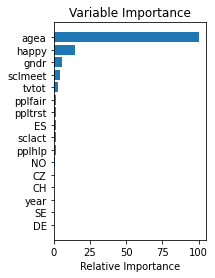

In [ ]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that __age__ and __happiness__ are the most important features in predicting whether or not someone lives with a partner.

# __Improve gradient boost model__




While this model is already doing alright, but there is definitely room for improvement.  

__Task:__ see how low you can get the error rates to go in the test set, based on your model in the training set using different strategies. 

You can learn more about the parameters for the gradient boost model [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and update the **params** table featured earlier, before we initialized and fit the model.

A few parameters to tune could be:
 - learning_rate
 - max_depth
 - n_estimators
 - loss
 - subsample
 - min_samples_split
 
You can then use the same metrics to evaluate your results.
---
**Increase iterations** to 1000 iterations


In [ ]:
# We'll make 1000 iterations, use 2-deep trees, and set our loss function.

params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print((
    '--1000 iterations, 2-deep trees, deviance loss function--\n'
    'Accuracy: {}\n'
    'Precision: {}\n'
    'Recall: {}'
).format(accuracy, precision, recall))
print()

cm = confusion_matrix(y_test, predict_test)
cm_train = confusion_matrix(y_train, predict_train)

train_tI_errors = cm_train[0][1] / y_train.size # false positives
train_tII_errors = cm_train[1][0] / y_train.size # false negatives

test_tI_errors = cm[0][1] / y_test.size # false positives
test_tII_errors = cm[1][0] / y_test.size # false negatives

print((
    'Training set accuracy:\n'
    'Percentage Type I errors: {}\n'
    'Percentage Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percentage Type I errors: {}\n'
    'Percentage Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

--1000 iterations, 2-deep trees, deviance loss function--
Accuracy: 0.7423312883435583
Precision: 0.7181628392484343
Recall: 0.5468998410174881

Training set accuracy:
Percentage Type I errors: 0.04342488875249348
Percentage Type II errors: 0.1677152063833052

Test set accuracy:
Percentage Type I errors: 0.08282208588957055
Percentage Type II errors: 0.17484662576687116


> Doubling iterations from 500 to 1000 did not have a drastic effect on errors. Test errors remained fairly similar and test set accuracy did not show drastic change. 

**Increase max_depth**

In [ ]:
# We'll make 1000 iterations, use 2-deep trees, and set our loss function.

params = {'n_estimators': 1000,
          'max_depth': 4,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print((
    '--1000 iterations, 4-deep trees, deviance loss function--\n'
    'Accuracy: {}\n'
    'Precision: {}\n'
    'Recall: {}'
).format(accuracy, precision, recall))
print()

cm = confusion_matrix(y_test, predict_test)
cm_train = confusion_matrix(y_train, predict_train)

train_tI_errors = cm_train[0][1] / y_train.size # false positives
train_tII_errors = cm_train[1][0] / y_train.size # false negatives

test_tI_errors = cm[0][1] / y_test.size # false positives
test_tII_errors = cm[1][0] / y_test.size # false negatives

print((
    'Training set accuracy:\n'
    'Percentage Type I errors: {}\n'
    'Percentage Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percentage Type I errors: {}\n'
    'Percentage Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

--1000 iterations, 4-deep trees, deviance loss function--
Accuracy: 0.7404907975460123
Precision: 0.708502024291498
Recall: 0.5564387917329093

Training set accuracy:
Percentage Type I errors: 0.010127359214362436
Percentage Type II errors: 0.0716587386834433

Test set accuracy:
Percentage Type I errors: 0.08834355828220859
Percentage Type II errors: 0.17116564417177915


> Increasing max_depth resulted in overfitting.

**Change Loss Function** to exponential

In [ ]:
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

print((
    '--1000 iterations, 4-deep trees, deviance loss function--\n'
    'Accuracy: {}\n'
    'Precision: {}\n'
    'Recall: {}'
).format(accuracy, precision, recall))
print()

cm = confusion_matrix(y_test, predict_test)
cm_train = confusion_matrix(y_train, predict_train)

train_tI_errors = cm_train[0][1] / y_train.size # false positives
train_tII_errors = cm_train[1][0] / y_train.size # false negatives

test_tI_errors = cm[0][1] / y_test.size # false positives
test_tII_errors = cm[1][0] / y_test.size # false negatives

print((
    'Training set accuracy:\n'
    'Percentage Type I errors: {}\n'
    'Percentage Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percentage Type I errors: {}\n'
    'Percentage Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

--1000 iterations, 4-deep trees, deviance loss function--
Accuracy: 0.7404907975460123
Precision: 0.6845878136200717
Recall: 0.6073131955484896

Training set accuracy:
Percentage Type I errors: 0.045880006137793465
Percentage Type II errors: 0.16894276507595518

Test set accuracy:
Percentage Type I errors: 0.10797546012269939
Percentage Type II errors: 0.15153374233128836


> Changing loss function from 'deviance' to 'exponential' did not improve our error rates from our initial model.